# MI Pseudocount Enhancement Demo

This notebook demonstrates the use of pseudocounts in mutual information calculations for RNA multiple sequence alignments.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add src directory to path
sys.path.append('..')
from src.analysis.mutual_information import calculate_mutual_information, get_adaptive_pseudocount
from src.analysis.rna_mi_pipeline.enhanced_mi import calculate_mutual_information_enhanced

## 1. Create Example MSAs with Different Sizes

We'll create example MSAs of different sizes to demonstrate the adaptive pseudocount selection.

In [2]:
# Create example MSAs
def create_example_msa(seq_count, seq_length=20, alphabet=['A', 'C', 'G', 'U'], seed=42):
    """Create a random MSA with specified number of sequences and length."""
    np.random.seed(seed)
    # For reproducibility, we'll create specific patterns
    base_seq = np.random.choice(alphabet, seq_length)
    
    # Create sequences with some correlations
    msa = []
    for i in range(seq_count):
        # Start with base sequence
        seq = base_seq.copy()
        
        # Introduce some correlations and mutations
        # If position 5 is A, position 15 is often G
        if seq[5] == 'A' and np.random.random() < 0.8:
            seq[15] = 'G'
            
        # Add some random mutations
        for j in range(seq_length):
            if np.random.random() < 0.1:  # 10% mutation rate
                seq[j] = np.random.choice(alphabet)
                
        msa.append(''.join(seq))
    
    return msa

# Create MSAs of different sizes
small_msa = create_example_msa(20)   # Small MSA (20 sequences)
medium_msa = create_example_msa(80)  # Medium MSA (80 sequences)
large_msa = create_example_msa(200)  # Large MSA (200 sequences)

print(f"Small MSA: {len(small_msa)} sequences")
print(f"Medium MSA: {len(medium_msa)} sequences")
print(f"Large MSA: {len(large_msa)} sequences")

Small MSA: 20 sequences
Medium MSA: 80 sequences
Large MSA: 200 sequences


## 2. Demonstrate Adaptive Pseudocount Selection

Let's see how the adaptive pseudocount selection works for different MSA sizes.

In [3]:
# Get pseudocount values for different MSA sizes
small_pc = get_adaptive_pseudocount(small_msa)
medium_pc = get_adaptive_pseudocount(medium_msa)
large_pc = get_adaptive_pseudocount(large_msa)

print(f"Adaptive pseudocount for small MSA: {small_pc}")
print(f"Adaptive pseudocount for medium MSA: {medium_pc}")
print(f"Adaptive pseudocount for large MSA: {large_pc}")

Adaptive pseudocount for small MSA: 0.5
Adaptive pseudocount for medium MSA: 0.2
Adaptive pseudocount for large MSA: 0.0


## 3. Compare MI Calculation With and Without Pseudocounts

Let's compare the MI matrices calculated with and without pseudocounts for a small MSA, where the effect should be most noticeable.

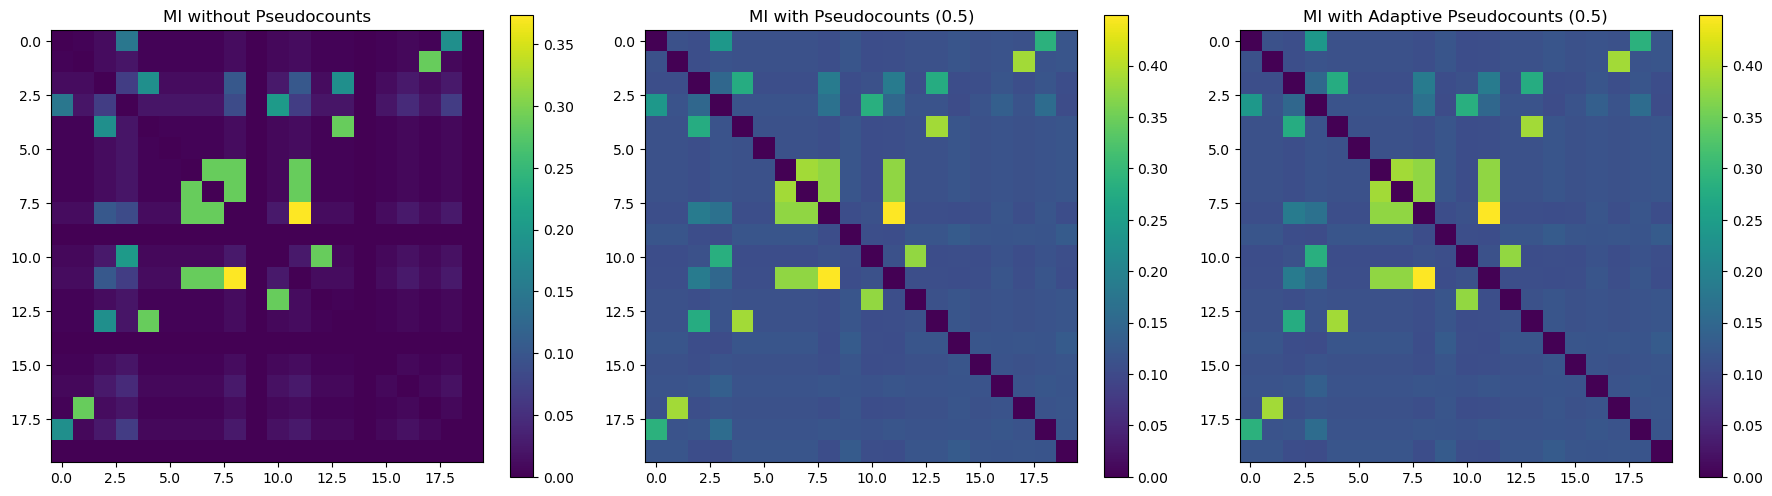

In [4]:
# Calculate MI without pseudocounts
mi_result_no_pc = calculate_mutual_information(small_msa, pseudocount=0.0)

# Calculate MI with pseudocounts
mi_result_with_pc = calculate_mutual_information(small_msa, pseudocount=0.5)

# Calculate MI with adaptive pseudocount
mi_result_adaptive = calculate_mutual_information(small_msa, pseudocount=None)

# Plot the MI matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(mi_result_no_pc['coupling_matrix'], cmap='viridis')
axes[0].set_title('MI without Pseudocounts')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mi_result_with_pc['coupling_matrix'], cmap='viridis')
axes[1].set_title('MI with Pseudocounts (0.5)')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(mi_result_adaptive['coupling_matrix'], cmap='viridis')
axes[2].set_title(f'MI with Adaptive Pseudocounts ({mi_result_adaptive["params"]["pseudocount"]})')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 4. Effect of Pseudocounts on Sparse MSAs

Let's create a very sparse MSA and see how pseudocounts improve the MI calculation.

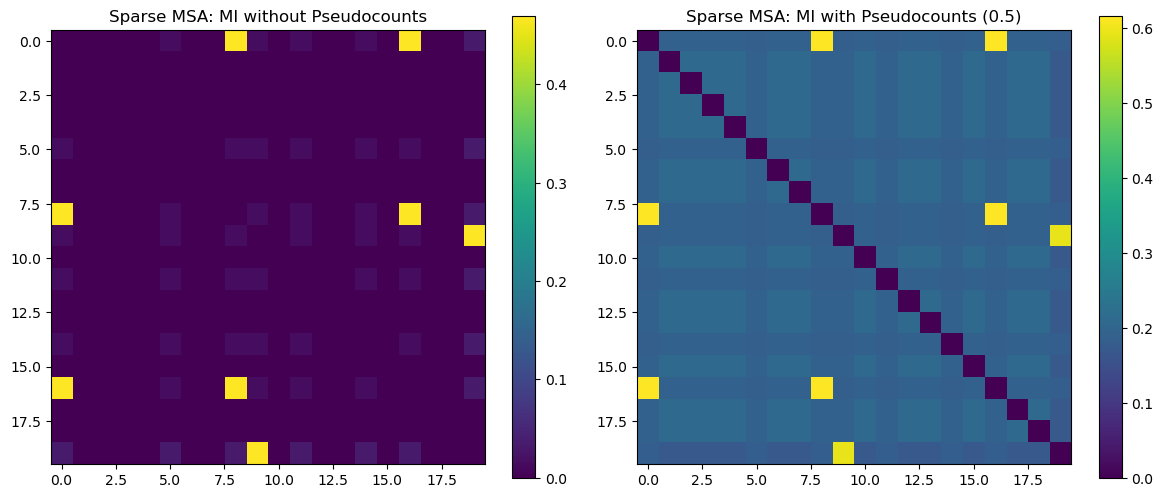

In [5]:
# Create a sparse MSA with few sequences
sparse_msa = create_example_msa(10, seq_length=20, seed=12345)

# Calculate MI without pseudocounts
sparse_mi_no_pc = calculate_mutual_information(sparse_msa, pseudocount=0.0)

# Calculate MI with pseudocounts
sparse_mi_with_pc = calculate_mutual_information(sparse_msa, pseudocount=0.5)

# Plot the MI matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(sparse_mi_no_pc['coupling_matrix'], cmap='viridis')
axes[0].set_title('Sparse MSA: MI without Pseudocounts')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(sparse_mi_with_pc['coupling_matrix'], cmap='viridis')
axes[1].set_title('Sparse MSA: MI with Pseudocounts (0.5)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 5. Enhanced MI with Pseudocounts and Sequence Weighting

Now let's see how pseudocounts integrate with sequence weighting in the enhanced MI implementation.

2025-04-12 19:02:39,353 - enhanced_mi - INFO - Calculated sequence weights (effective number of sequences: 9.4)
2025-04-12 19:02:39,356 - enhanced_mi - INFO - Calculated sequence weights (effective number of sequences: 9.4)


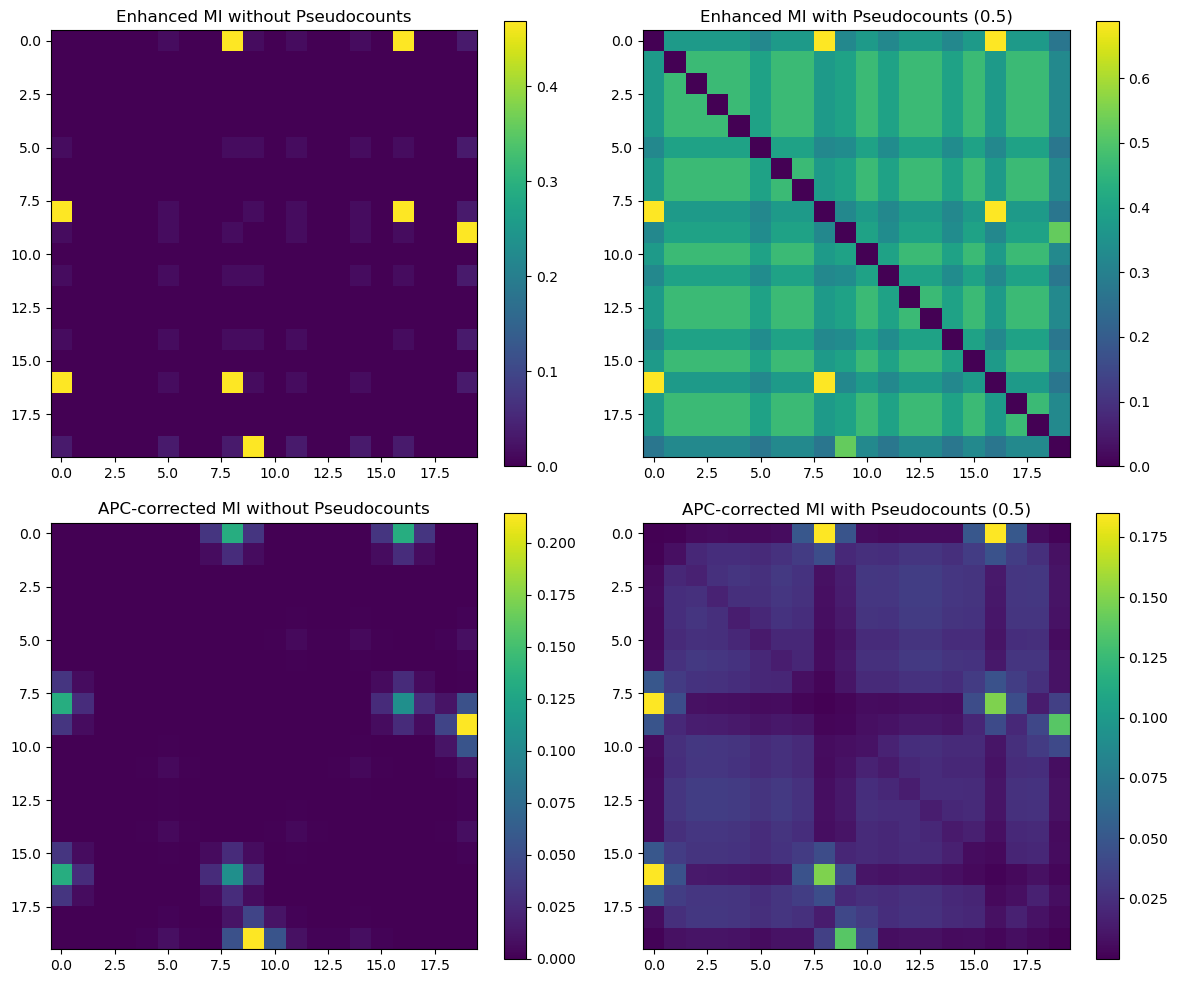

In [6]:
# Calculate enhanced MI with and without pseudocounts
enhanced_mi_no_pc = calculate_mutual_information_enhanced(sparse_msa, pseudocount=0.0)
enhanced_mi_with_pc = calculate_mutual_information_enhanced(sparse_msa, pseudocount=0.5)

# Plot the MI matrices and APC-corrected matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Raw MI matrices
im00 = axes[0, 0].imshow(enhanced_mi_no_pc['mi_matrix'], cmap='viridis')
axes[0, 0].set_title('Enhanced MI without Pseudocounts')
plt.colorbar(im00, ax=axes[0, 0])

im01 = axes[0, 1].imshow(enhanced_mi_with_pc['mi_matrix'], cmap='viridis')
axes[0, 1].set_title('Enhanced MI with Pseudocounts (0.5)')
plt.colorbar(im01, ax=axes[0, 1])

# APC-corrected matrices
im10 = axes[1, 0].imshow(enhanced_mi_no_pc['apc_matrix'], cmap='viridis')
axes[1, 0].set_title('APC-corrected MI without Pseudocounts')
plt.colorbar(im10, ax=axes[1, 0])

im11 = axes[1, 1].imshow(enhanced_mi_with_pc['apc_matrix'], cmap='viridis')
axes[1, 1].set_title('APC-corrected MI with Pseudocounts (0.5)')
plt.colorbar(im11, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## 6. Top MI Pairs Analysis

Let's analyze how pseudocounts affect the identification of top correlated pairs.

In [7]:
# Get top pairs from enhanced MI results
top_pairs_no_pc = enhanced_mi_no_pc['top_pairs'][:10]  # Get top 10 pairs
top_pairs_with_pc = enhanced_mi_with_pc['top_pairs'][:10]  # Get top 10 pairs

print("Top 10 correlated pairs without pseudocounts:")
for i, j, score in top_pairs_no_pc:
    print(f"Positions {i}-{j}: {score:.4f}")

print("\nTop 10 correlated pairs with pseudocounts:")
for i, j, score in top_pairs_with_pc:
    print(f"Positions {i}-{j}: {score:.4f}")

# Check how many pairs are shared between the two methods
no_pc_pairs = {(i, j) for i, j, _ in top_pairs_no_pc}
with_pc_pairs = {(i, j) for i, j, _ in top_pairs_with_pc}
shared_pairs = no_pc_pairs.intersection(with_pc_pairs)

print(f"\nNumber of shared pairs: {len(shared_pairs)} out of 10")

KeyError: 'top_pairs'

## 7. Conclusion

The pseudocount enhancement improves mutual information calculations, especially for sparse MSAs with few sequences. Key benefits include:

1. **Improved statistical robustness**: Pseudocounts help avoid zero probabilities, resulting in more stable MI estimates.
2. **Adaptive selection**: The pseudocount value is automatically selected based on MSA size, with higher values for smaller MSAs.
3. **Integration with sequence weighting**: Pseudocounts can be used alongside sequence weighting in the enhanced MI implementation.
4. **Compatibility with APC correction**: Pseudocounts work well with the APC correction step, resulting in cleaner signal.

This enhancement is particularly valuable for the ~10% of our RNA dataset that has relatively few sequences in their MSAs.